# General Information of the Patients Database

In [37]:
from google.cloud import bigquery
import pandas as pd

# Initialize a BigQuery client
client = bigquery.Client()

In [38]:
query = """
SELECT
    age,
    COUNT(SUBJECT_ID) AS subject_count
FROM (
    SELECT
        a.SUBJECT_ID,
        MAX(r.age) AS age
    FROM
        DATASET.ADMISSIONS a
    JOIN
        DATASET.RAFA r ON a.SUBJECT_ID = r.SUBJECT_ID
    GROUP BY
        a.SUBJECT_ID
) subquery
GROUP BY
    age
ORDER BY
    age;
"""
df = client.query(query).to_dataframe()

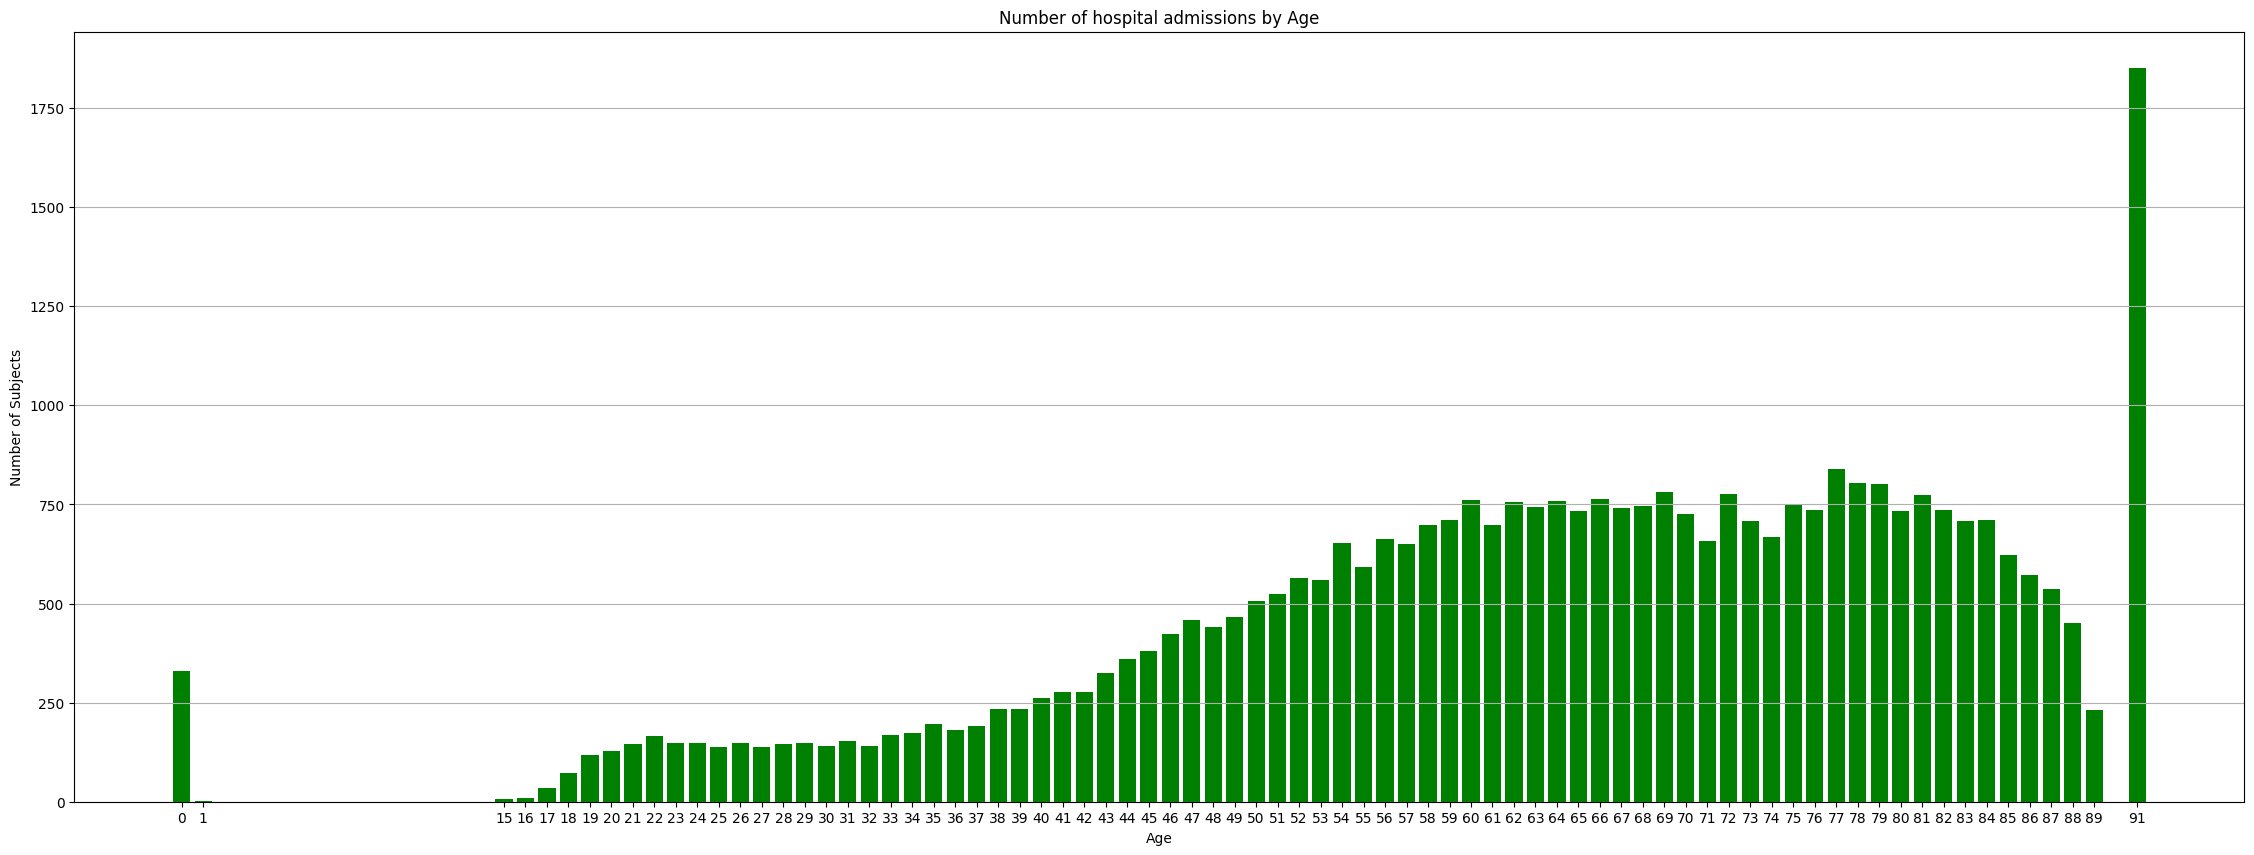

In [39]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert the 'age' column to integers
df['age'] = df['age'].astype(int)

# Plot the graph
plt.figure(figsize=(28,10))
plt.bar(df['age'], df['subject_count'], color='green')
plt.xlabel('Age')
plt.ylabel('Number of Subjects')
plt.title('Number of hospital admissions by Age')
plt.xticks(df['age'])
plt.grid(axis='y')
plt.show()

In [40]:
query = """
SELECT
    GENDER,
    COUNT(SUBJECT_ID) AS patient_count
FROM (
    SELECT
        a.SUBJECT_ID,
        MAX(GENDER) AS GENDER
    FROM
        DATASET.ADMISSIONS a
    JOIN
        DATASET.PATIENTS r ON a.SUBJECT_ID = r.SUBJECT_ID
    GROUP BY
        a.SUBJECT_ID
) subquery
GROUP BY
    GENDER
ORDER BY
    GENDER;
"""
df = client.query(query).to_dataframe()

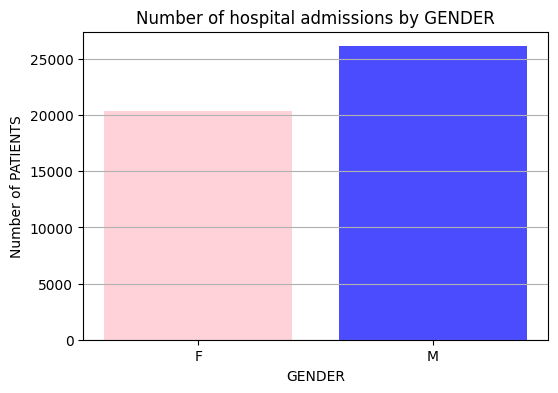

In [41]:
import pandas as pd
import matplotlib.pyplot as plt

# Plot the graph
plt.figure(figsize=(6,4))
plt.bar(df['GENDER'], df['patient_count'], color=['pink','blue'], alpha=0.7)
plt.xlabel('GENDER')
plt.ylabel('Number of PATIENTS')
plt.title('Number of hospital admissions by GENDER')
plt.grid(axis='y')
plt.show()

In [42]:
query = """
SELECT
    ETHNICITY,
    COUNT(SUBJECT_ID) AS patient_count
FROM (
    SELECT
        a.SUBJECT_ID,
        r.ETHNICITY
    FROM
        DATASET.ADMISSIONS a
    JOIN
        DATASET.GLOBAL_s r ON a.SUBJECT_ID = r.SUBJECT_ID
    GROUP BY
        a.SUBJECT_ID, r.ETHNICITY
) subquery
GROUP BY
    ETHNICITY
"""
df = client.query(query).to_dataframe()

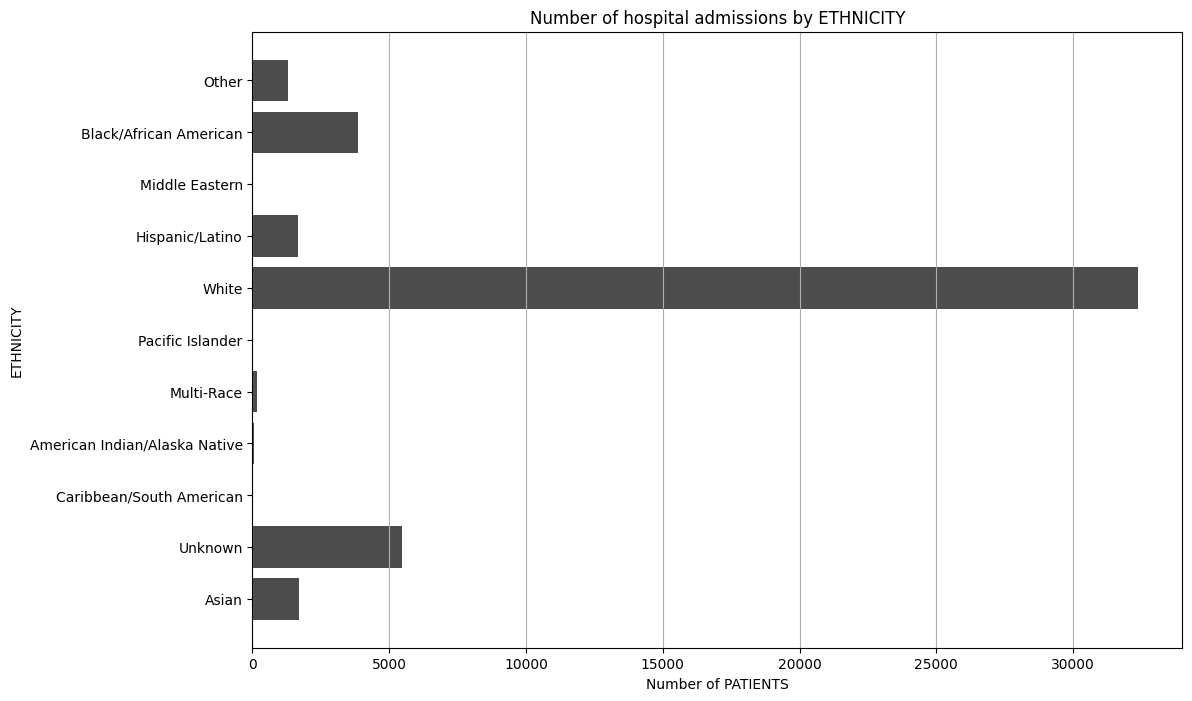

In [43]:
import pandas as pd
import matplotlib.pyplot as plt

# Plot the graph
plt.figure(figsize=(12, 8))
plt.barh(df['ETHNICITY'], df['patient_count'], color='black', alpha=0.7)
plt.xlabel('Number of PATIENTS')
plt.ylabel('ETHNICITY')
plt.title('Number of hospital admissions by ETHNICITY')
plt.grid(axis='x')
plt.show()

In [44]:
query = """
SELECT
    ICD9_CODE,
    COUNT(SUBJECT_ID) AS patient_count
FROM (
    SELECT
        a.SUBJECT_ID,
        r.ICD9_CODE
    FROM
        DATASET.ADMISSIONS a
    JOIN
        DATASET.DIAGNOSES_ICD r ON a.SUBJECT_ID = r.SUBJECT_ID
    GROUP BY
        a.SUBJECT_ID, r.ICD9_CODE
) subquery
GROUP BY
    ICD9_CODE
ORDER BY patient_count desc
LIMIT 20
"""
df = client.query(query).to_dataframe()

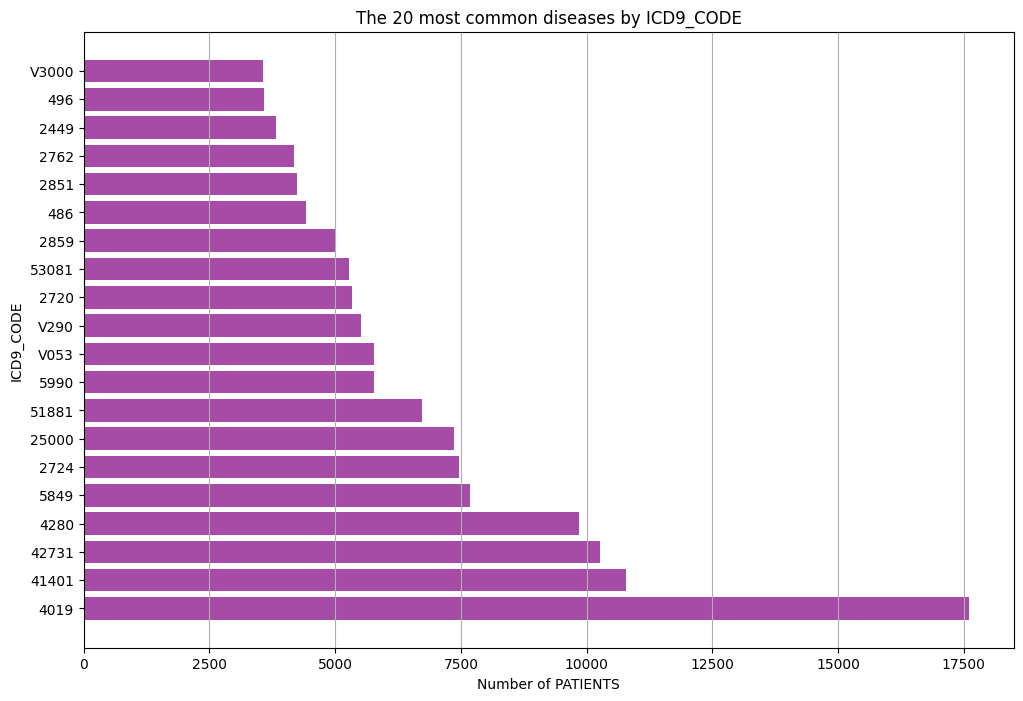

In [46]:
import pandas as pd
import matplotlib.pyplot as plt

# Plot the graph
plt.figure(figsize=(12, 8))
plt.barh(df['ICD9_CODE'], df['patient_count'], color='purple', alpha=0.7)
plt.xlabel('Number of PATIENTS')
plt.ylabel('ICD9_CODE')
plt.title('The 20 most common diseases by ICD9_CODE')
plt.grid(axis='x')
plt.show()

In [10]:
query = """
SELECT
    CASE
        WHEN p.DOD_HOSP IS NOT NULL THEN 'Died'
        ELSE 'Survived'
    END AS status,
    COUNT(a.SUBJECT_ID) AS patient_count
FROM
    DATASET.ADMISSIONS a
JOIN
    DATASET.PATIENTS p ON a.SUBJECT_ID = p.SUBJECT_ID
GROUP BY
    status
"""
df = client.query(query).to_dataframe()

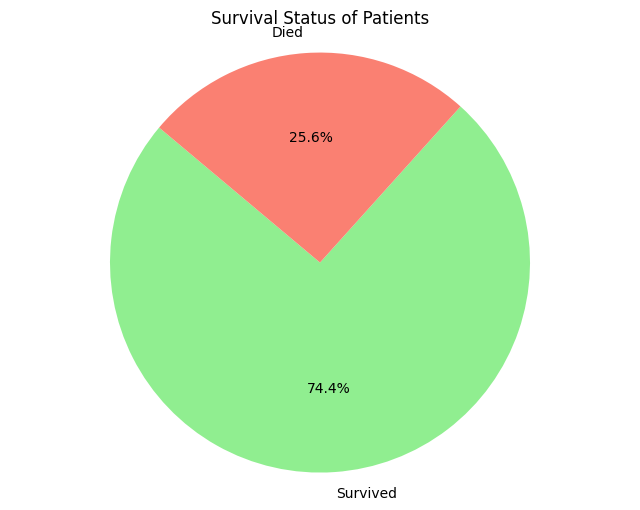

In [11]:
total_patients = df['patient_count'].sum()
df['percentage'] = (df['patient_count'] / total_patients) * 100

# Create a pie chart
plt.figure(figsize=(8, 6))
plt.pie(df['patient_count'], labels=df['status'], autopct='%1.1f%%', startangle=140, colors=['lightgreen', 'salmon'])
plt.title('Survival Status of Patients')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

In [12]:
query = """
SELECT
    ICD9_CODE,
    COUNT(SUBJECT_ID) AS patient_count
FROM (
    SELECT
        a.SUBJECT_ID,
        r.ICD9_CODE,
        MAX(p.DOD_HOSP) as DOD_HOSP
    FROM
        DATASET.ADMISSIONS a
    JOIN
        DATASET.DIAGNOSES_ICD r ON a.SUBJECT_ID = r.SUBJECT_ID
    JOIN
        DATASET.PATIENTS p ON a.SUBJECT_ID = p.SUBJECT_ID
    WHERE r.SEQ_NUM=1
    GROUP BY
        a.SUBJECT_ID, r.ICD9_CODE
) subquery
WHERE DOD_HOSP is not null
GROUP BY
    ICD9_CODE
ORDER BY patient_count desc
LIMIT 10
"""
df = client.query(query).to_dataframe()

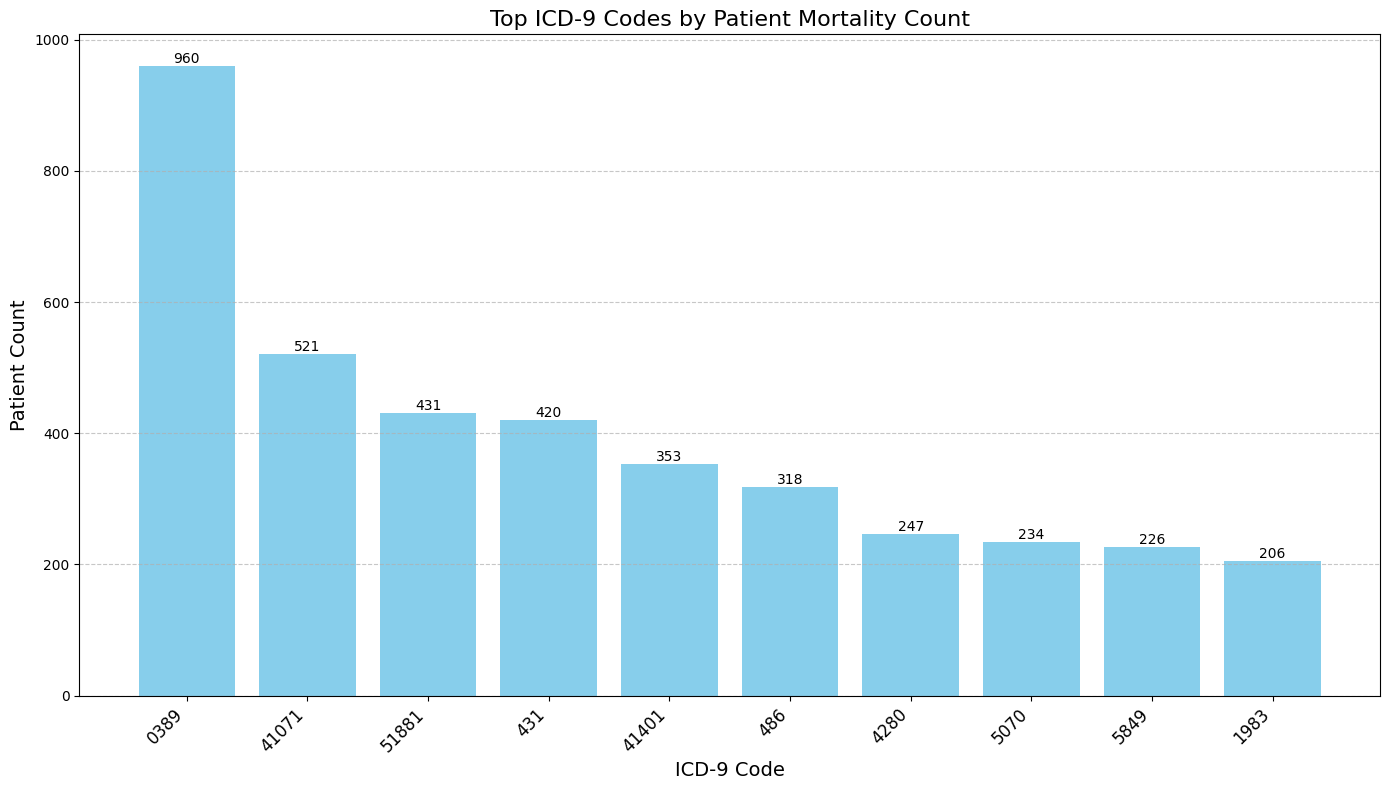

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df is the DataFrame obtained from the query
# Here we use the DataFrame df to create the visualization

# Sort the DataFrame by patient_count for clarity in the plot
df = df.sort_values(by='patient_count', ascending=False)

# Plotting the data
plt.figure(figsize=(14, 8))
bars = plt.bar(df['ICD9_CODE'], df['patient_count'], color='skyblue')

# Adding title and labels
plt.title('Top ICD-9 Codes by Patient Mortality Count', fontsize=16)
plt.xlabel('ICD-9 Code', fontsize=14)
plt.ylabel('Patient Count', fontsize=14)

# Adding annotations to the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, int(yval), ha='center', va='bottom')

# Rotating x-axis labels for better readability
plt.xticks(rotation=45, ha='right', fontsize=12)

# Adding grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.tight_layout()
plt.show()

In [14]:
query = """
SELECT
    decade,
    SUM(subject_count) AS total_subjects,
    SUM(deceased_subject_count) AS total_deceased_subjects,
    CASE
        WHEN SUM(subject_count) > 0 THEN SUM(deceased_subject_count) / SUM(subject_count)
        ELSE 0
    END AS death_rate
FROM (
    SELECT
        CAST(FLOOR(age / 10) AS INT64) * 10 AS decade,
        COUNT(SUBJECT_ID) AS subject_count,
        SUM(IF(DOD_HOSP IS NOT NULL, 1, 0)) AS deceased_subject_count
    FROM (
        SELECT
            a.SUBJECT_ID,
            MAX(r.age) AS age,
            MAX(p.DOD_HOSP) AS DOD_HOSP
        FROM
            `DATASET.ADMISSIONS` a
        JOIN
            `DATASET.RAFA` r ON a.SUBJECT_ID = r.SUBJECT_ID
        JOIN
            `DATASET.PATIENTS` p ON a.SUBJECT_ID = p.SUBJECT_ID
        GROUP BY
            a.SUBJECT_ID
    )
    GROUP BY
        decade
)
GROUP BY
    decade
ORDER BY
    decade;
"""
df = client.query(query).to_dataframe()

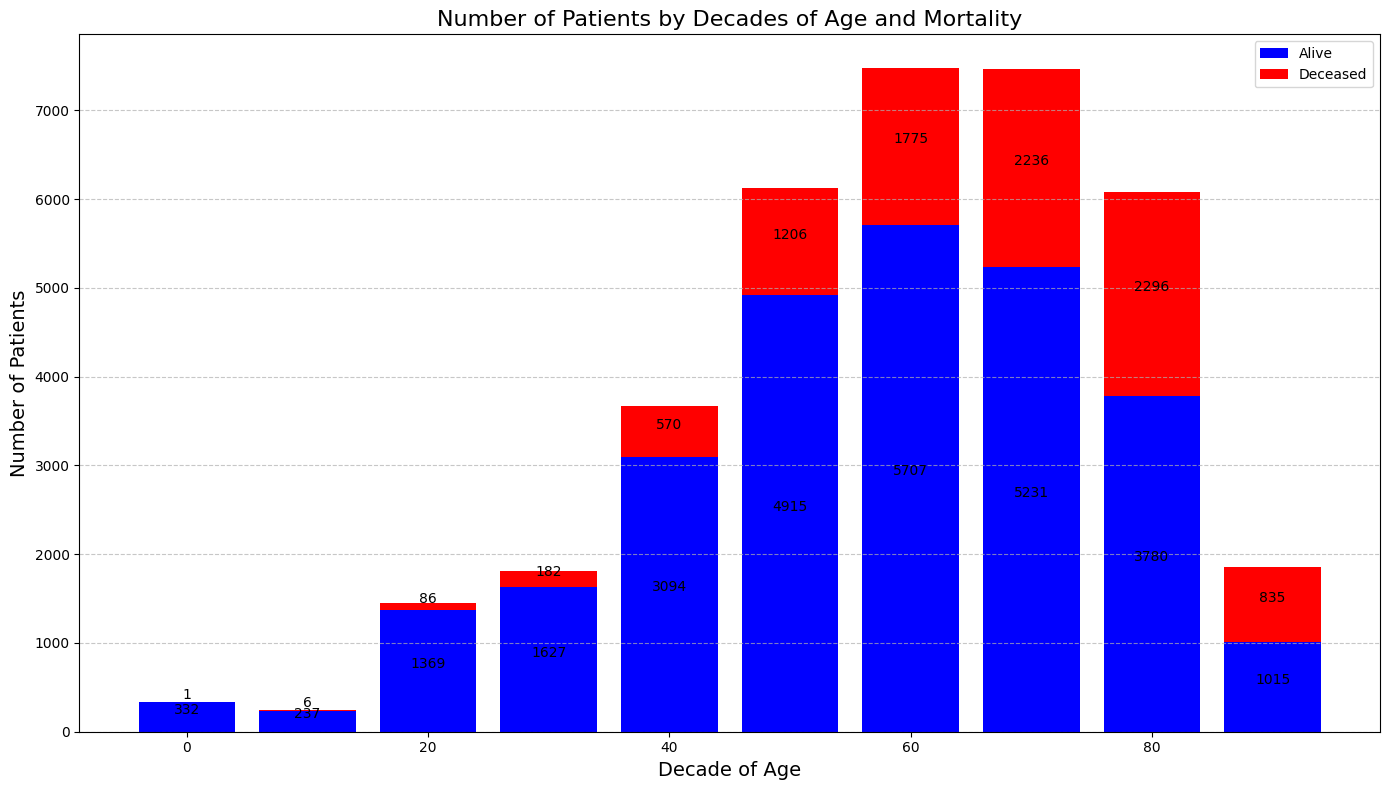

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming the DataFrame 'df' contains the result of the SQL query
df['total_alive_subjects'] = df['total_subjects'] - df['total_deceased_subjects']

# Plotting the data
plt.figure(figsize=(14, 8))

bar_width = 8

# Plotting the bars for total alive subjects
bars_alive = plt.bar(df['decade'], df['total_alive_subjects'], color='blue', label='Alive', width=bar_width)

# Plotting the bars for total deceased subjects on top of the bars for alive subjects
bars_dead = plt.bar(df['decade'], df['total_deceased_subjects'], bottom=df['total_alive_subjects'], color='red', label='Deceased', width=bar_width)

# Adding title and labels
plt.title('Number of Patients by Decades of Age and Mortality', fontsize=16)
plt.xlabel('Decade of Age', fontsize=14)
plt.ylabel('Number of Patients', fontsize=14)

# Adding a legend
plt.legend()

# Adding annotations to the bars
for bar_alive, bar_dead in zip(bars_alive, bars_dead):
    yval_alive = bar_alive.get_height()
    yval_dead = bar_dead.get_height()
    total = yval_alive + yval_dead
    plt.text(bar_alive.get_x() + bar_alive.get_width()/2.0, yval_alive / 2, int(yval_alive), ha='center', va='bottom', color='black')
    plt.text(bar_dead.get_x() + bar_dead.get_width()/2.0, yval_alive + yval_dead / 2, int(yval_dead), ha='center', va='bottom', color='black')

# Adding grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.tight_layout()
plt.show()

In [16]:
query = """
SELECT
    p.GENDER,
    i.LOS
FROM
    `DATASET.ADMISSIONS` a
JOIN
    `DATASET.ICUSTAYS` i ON a.SUBJECT_ID = i.SUBJECT_ID
JOIN
    `DATASET.PATIENTS` p ON a.SUBJECT_ID = p.SUBJECT_ID
WHERE LOS is not null
ORDER BY LOS desc
"""
df = client.query(query).to_dataframe()

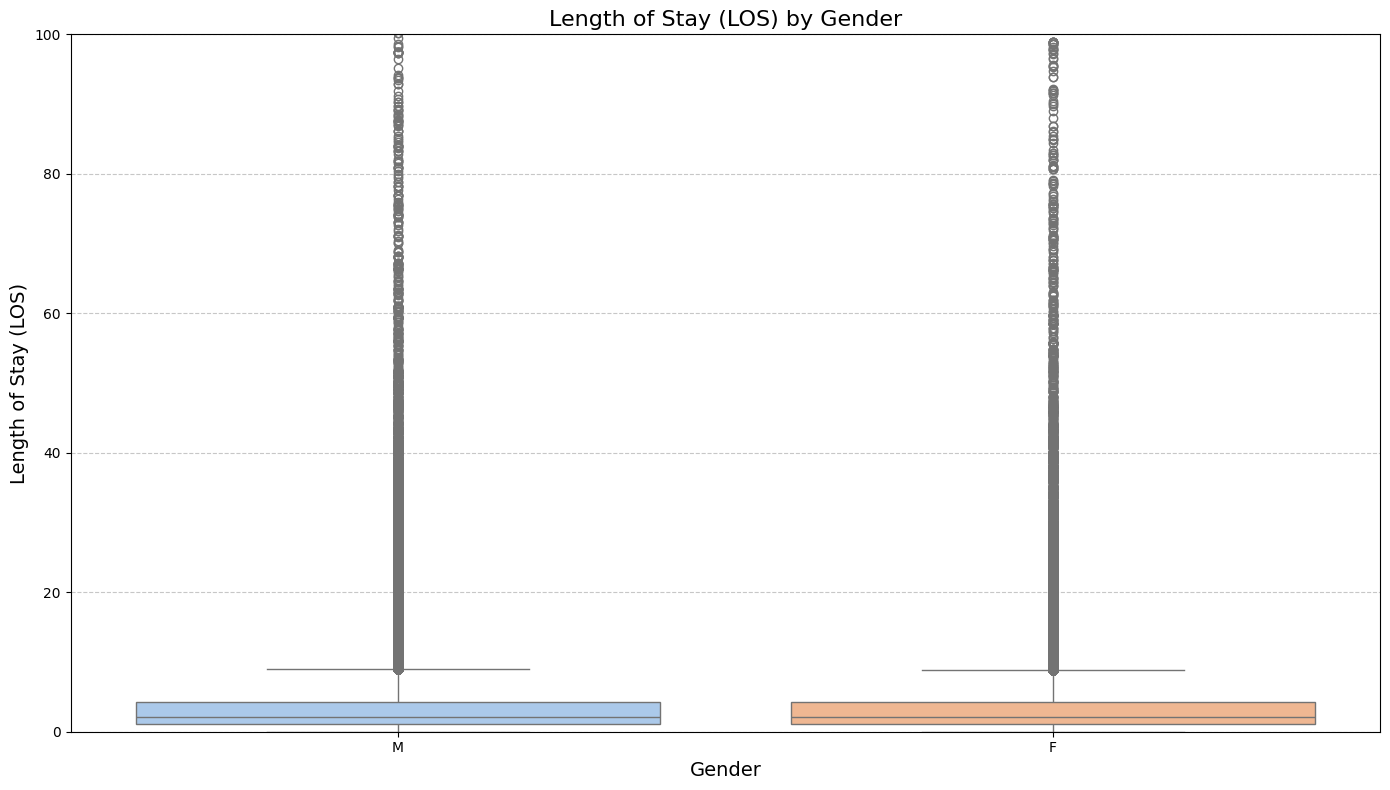

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming the DataFrame 'df' contains the result of the SQL query

# Plotting the data
plt.figure(figsize=(14, 8))

# Creating a box plot with thinner boxes
sns.boxplot(x='GENDER', y='LOS', data=df, hue='GENDER', palette='pastel', linewidth=1, dodge=False)

# Adding title and labels
plt.title('Length of Stay (LOS) by Gender', fontsize=16)
plt.xlabel('Gender', fontsize=14)
plt.ylabel('Length of Stay (LOS)', fontsize=14)

# Setting y-axis limits
plt.ylim(0, 100)  # Adjust the limits as needed to focus on the main distribution

# Removing the legend
plt.legend().remove()

# Adding grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.tight_layout()
plt.show()

#Information of each patient
## Graphics on the patient's vitals

In [141]:
client = bigquery.Client()

def get_patient_data(subject_id):
    query = """
    SELECT
          d.LABEL,
          c.CHARTTIME,
          c.VALUE,
          c.VALUENUM
    FROM
          `DATASET.CHARTEVENTS` c
    JOIN
          `DATASET.D_ITEMS` d
    ON
          c.ITEMID = CAST(d.ITEMID as STRING)
    WHERE
          c.SUBJECT_ID = @subject_id AND c.VALUENUM IS NOT NULL AND c.ITEMID IN ("220045", "220050", "220051", "220052", "220179", "220180", "220181", "220210", "220277", "220739")
    order by c.VALUENUM
    """

    job_config = bigquery.QueryJobConfig(
        query_parameters=[
            bigquery.ScalarQueryParameter("subject_id", "STRING", str(subject_id))
        ]
    )
    # Fetch the data
    df = client.query(query, job_config=job_config).to_dataframe()

    # Convert VALUENUM to Int64 type
    df['VALUENUM'] = df['VALUENUM'].astype('Int64')
    df['CHARTTIME'] = pd.to_datetime(df['CHARTTIME'])  # Ensure CHARTTIME is in datetime format
    return df

In [138]:
# Create input widget for SUBJECT_ID
subject_id_input = widgets.Text(
    value='',
    placeholder='Enter SUBJECT_ID',
    description='SUBJECT_ID:',
    disabled=False,
    style={'description_width': 'initial'}
)

# Create a button to submit the form
submit_button = widgets.Button(
    description='Submit',
    disabled=False,
    button_style='primary',
    tooltip='Click to submit',
    icon='check'
)

# Output widget to display the plot
output = widgets.Output()

# Function to plot patient data
def plot_patient_data(df):
    unique_labels = df['LABEL'].unique()
    num_plots = len(unique_labels)

    # Create subplots with the specified figure size
    fig, axes = plt.subplots(num_plots, 1, figsize=(15, 5 * num_plots), sharex=True)

    # Ensure axes is always iterable
    if num_plots == 1:
        axes = [axes]

    # Plot each label in a separate subplot
    for i, label in enumerate(unique_labels):
        label_data = df[df['LABEL'] == label].sort_values(by='CHARTTIME')
        axes[i].plot(label_data['CHARTTIME'], label_data['VALUENUM'], marker='o')
        axes[i].set_title(label)
        axes[i].set_ylabel('Value')
        axes[i].grid(True)

    # Set the x-axis label
    plt.xlabel('CHARTTIME')
    plt.tight_layout()
    plt.show()

# Function to handle button click
def on_button_click(b):
    subject_id = subject_id_input.value
    try:
        df = get_patient_data(subject_id)
        with output:
            output.clear_output()
            plot_patient_data(df)
    except Exception as e:
        with output:
            output.clear_output()
            display(widgets.HTML(f"<p style='color:red;'>Error: {e}</p>"))

# Assign the on_button_click function to the button
submit_button.on_click(on_button_click)

# Create a vertical box layout for input and output
vbox = widgets.VBox([subject_id_input, submit_button, output])

# Display the widgets
display(vbox)

## Information regarding the General Information, Diagnoses, Length Of Stay and Survivor Status of each patient

In [142]:
from google.cloud import bigquery
import pandas as pd

def get_patient_data1(subject_id):
    client = bigquery.Client()

    query = f"""
    WITH AgeCounts AS (
        SELECT
            age,
            COUNT(SUBJECT_ID) AS subject_count
        FROM (
            SELECT
                a.SUBJECT_ID,
                MAX(r.age) AS age
            FROM
                `DATASET.ADMISSIONS` a
            JOIN
                `DATASET.RAFA` r ON a.SUBJECT_ID = r.SUBJECT_ID
            WHERE
                a.SUBJECT_ID = {subject_id}
            GROUP BY
                a.SUBJECT_ID
        ) subquery
        GROUP BY
            age
    ),
    GenderCounts AS (
        SELECT
            GENDER,
            COUNT(SUBJECT_ID) AS patient_count
        FROM (
            SELECT
                a.SUBJECT_ID,
                MAX(GENDER) AS GENDER
            FROM
                `DATASET.ADMISSIONS` a
            JOIN
                `DATASET.PATIENTS` r ON a.SUBJECT_ID = r.SUBJECT_ID
            WHERE
                a.SUBJECT_ID = {subject_id}
            GROUP BY
                a.SUBJECT_ID
        ) subquery
        GROUP BY
            GENDER
    ),
    EthnicityCounts AS (
        SELECT
            ETHNICITY,
            COUNT(SUBJECT_ID) AS patient_count
        FROM (
            SELECT
                a.SUBJECT_ID,
                r.ETHNICITY
            FROM
                `DATASET.ADMISSIONS` a
            JOIN
                `DATASET.GLOBAL_s` r ON a.SUBJECT_ID = r.SUBJECT_ID
            WHERE
                a.SUBJECT_ID = {subject_id}
            GROUP BY
                a.SUBJECT_ID, r.ETHNICITY
        ) subquery
        GROUP BY
            ETHNICITY
    ),
    VisitCounts AS (
        SELECT
            a.SUBJECT_ID,
            a.HADM_ID,
            ROW_NUMBER() OVER (PARTITION BY a.SUBJECT_ID ORDER BY a.ADMITTIME) AS visit_number
        FROM
            `DATASET.ADMISSIONS` a
        WHERE
            a.SUBJECT_ID = {subject_id}
    ),
    DiagnosisCounts AS (
        SELECT
            v.visit_number,
            d.LONG_TITLE,
            COUNT(r.SUBJECT_ID) AS patient_count
        FROM
            `DATASET.ADMISSIONS` a
        JOIN
            `DATASET.DIAGNOSES_ICD` r ON a.SUBJECT_ID = r.SUBJECT_ID AND a.HADM_ID = r.HADM_ID
        JOIN
            `DATASET.DIAGNOSES` d ON r.ICD9_CODE = d.ICD9_CODE
        JOIN
            VisitCounts v ON a.SUBJECT_ID = v.SUBJECT_ID AND a.HADM_ID = v.HADM_ID
        WHERE
            a.SUBJECT_ID = {subject_id}
        GROUP BY
            v.visit_number, d.LONG_TITLE
    ),
    SurvivalStatus AS (
        SELECT
            CASE
                WHEN p.DOD_HOSP IS NOT NULL THEN 'Died'
                ELSE 'Survived'
            END AS status,
            COUNT(a.SUBJECT_ID) AS patient_count
        FROM
            `DATASET.ADMISSIONS` a
        JOIN
            `DATASET.PATIENTS` p ON a.SUBJECT_ID = p.SUBJECT_ID
        WHERE
            a.SUBJECT_ID = {subject_id}
        GROUP BY
            status
    ),
    ReligionCounts AS (
        SELECT
            a.RELIGION,
            COUNT(a.SUBJECT_ID) AS patient_count
        FROM
            `DATASET.ADMISSIONS` a
        WHERE
            a.SUBJECT_ID = {subject_id}
        GROUP BY
            a.RELIGION
    ),
    LOSCounts AS (
        SELECT
            v.visit_number,
            i.LOS
        FROM
            `DATASET.ICUSTAYS` i
        JOIN
            VisitCounts v ON i.SUBJECT_ID = v.SUBJECT_ID AND i.HADM_ID = v.HADM_ID
        WHERE
            i.SUBJECT_ID = {subject_id}
    )

    SELECT
        'Age' AS Attribute,
        CAST(age AS STRING) AS Value,
        subject_count AS Count
    FROM
        AgeCounts
    UNION ALL
    SELECT
        'Gender' AS Attribute,
        GENDER AS Value,
        patient_count AS Count
    FROM
        GenderCounts
    UNION ALL
    SELECT
        'Ethnicity' AS Attribute,
        ETHNICITY AS Value,
        patient_count AS Count
    FROM
        EthnicityCounts
    UNION ALL
    SELECT
        'Diagnosis' AS Attribute,
        CONCAT('Visit ', CAST(visit_number AS STRING), ': ', LONG_TITLE) AS Value,
        patient_count AS Count
    FROM
        DiagnosisCounts
    UNION ALL
    SELECT
        'SurvivalStatus' AS Attribute,
        status AS Value,
        patient_count AS Count
    FROM
        SurvivalStatus
    UNION ALL
    SELECT
        'Religion' AS Attribute,
        RELIGION AS Value,
        null AS Count
    FROM
        ReligionCounts
    UNION ALL
    SELECT
        'Number of Visits' AS Attribute,
        'Visits' AS Value,
        COUNT(*) AS Count
    FROM
        VisitCounts
    UNION ALL
    SELECT
        'Length of Stay' AS Attribute,
        CONCAT('Visit ', CAST(visit_number AS STRING), ': ', CAST(LOS AS STRING), ' days') AS Value,
        1 AS Count
    FROM
        LOSCounts
    ORDER BY
        Attribute, Value;
    """

    # Execute the query and convert the results to a pandas DataFrame
    df = client.query(query).to_dataframe()

    # Return the DataFrame
    return df


In [143]:
import ipywidgets as widgets
from IPython.display import display, clear_output, HTML
import pandas as pd

# Create input widget for SUBJECT_ID
subject_id_input = widgets.Text(
    value='',
    placeholder='Enter SUBJECT_ID',
    description='SUBJECT_ID:',
    disabled=False,
    style={'description_width': 'initial'}
)

# Create a button to submit the form
submit_button = widgets.Button(
    description='Submit',
    disabled=False,
    button_style='primary',
    tooltip='Click to submit',
    icon='check'
)

# Output widget to display the result
output = widgets.Output()

def display_patient_info(df):
    # Clear previous output
    output.clear_output()

    with output:
        # General patient information
        general_info = df[df['Attribute'].isin(['Age', 'Ethnicity', 'Gender', 'Religion'])]
        visit_info = df[df['Attribute'] == 'Number of Visits']
        survival_info = df[df['Attribute'] == 'SurvivalStatus']

        # Create widgets for general patient information
        general_widgets = [widgets.HTML("<h4>General Information</h4>")]
        for attribute, value in zip(general_info['Attribute'], general_info['Value']):
            label = widgets.Label(f"{attribute}:")
            info = widgets.HTML(value)
            general_widgets.append(widgets.HBox([label, info]))

        # Number of visits
        visits_widgets = []
        visits = 0
        for attribute, value in zip(visit_info['Attribute'], visit_info['Count']):
            label = widgets.Label(f"{attribute}:")
            info = widgets.HTML(str(value))  # Convert to string
            visits_widgets.append(widgets.HBox([label, info]))
            visits = value

        # Diagnoses and Length of Stay (LOS) for each visit
        diagnoses_los_widgets = []
        for visit in range(1, visits + 1):
            visit_diagnoses = df[df['Value'].str.startswith(f'Visit {visit}:') & df['Attribute'].str.contains('Diagnosis')]
            visit_los = df[df['Value'].str.startswith(f'Visit {visit}:') & df['Attribute'].str.contains('Length of Stay')]

            if not visit_diagnoses.empty or not visit_los.empty:
                visit_label = widgets.HTML(f"<h4>Visit {visit}</h4>")
                diagnoses_los_widgets.append(visit_label)

                for attribute, value in zip(visit_diagnoses['Attribute'], visit_diagnoses['Value']):
                    stripped_value = value.replace(f'Visit {visit}: ', '')  # Remove "Visit X: " prefix
                    label = widgets.Label(f"{attribute}:")
                    info = widgets.HTML(stripped_value)
                    diagnoses_los_widgets.append(widgets.HBox([label, info]))

                for attribute, value in zip(visit_los['Attribute'], visit_los['Value']):
                    stripped_value = value.replace(f'Visit {visit}: ', '')  # Remove "Visit X: " prefix
                    label = widgets.Label(f"{attribute}:")
                    info = widgets.HTML(stripped_value)
                    diagnoses_los_widgets.append(widgets.HBox([label, info]))

        # Survival status
        survival_widgets = [widgets.HTML("<h4>Survival Status</h4>")]
        for attribute, value in zip(survival_info['Attribute'], survival_info['Value']):
            label = widgets.Label(f"{attribute}:")
            info = widgets.HTML(value)
            survival_widgets.append(widgets.HBox([label, info]))

        # Arrange all widgets in a vertical layout
        vbox = widgets.VBox(general_widgets + visits_widgets + diagnoses_los_widgets + survival_widgets)
        display(vbox)

def on_button_click(b):
    subject_id = subject_id_input.value
    try:
        df = get_patient_data1(subject_id)
        display_patient_info(df)
    except Exception as e:
        with output:
            output.clear_output()
            display(widgets.HTML(f"<p style='color:red;'>Error: {e}</p>"))

# Assign the on_button_click function to the button
submit_button.on_click(on_button_click)

# Create a vertical box layout for input and output
vbox = widgets.VBox([subject_id_input, submit_button, output])

# Display the widgets
display(vbox)
